In [39]:
import os 
import sys
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.metrics import calc_y_metrics
from utils.validate_data import validate_data
pd.set_option('display.max_columns', None)
plt.rc('font', family='NanumGothic')

In [2]:
# Importing dataset
train_data_ = pd.read_csv('./Data/데이터챌린지_학습용데이터_수정.csv', index_col='DateTime')
test_data_ = pd.read_csv('./Data/데이터챌린지_시험용데이터_수정.csv', index_col='DateTime')

print(train_data_.info())
print("")
print(test_data_.info())

<class 'pandas.core.frame.DataFrame'>
Index: 144000 entries, 20XX-07-24  12:00:00 AM to 20XX-10-31  11:59:00 PM
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Zone 8 로온도          144000 non-null  float64
 1   Zone 2 공기비          143955 non-null  float64
 2   Zone 4 공기비          143955 non-null  float64
 3   Zone 2 로온도          144000 non-null  float64
 4   Zone 5 연료 유량        143892 non-null  float64
 5   Zone 1 공기비          143955 non-null  float64
 6   Zone 6 공기비          143955 non-null  float64
 7   열교환기 전단 배가스 온도      144000 non-null  float64
 8   연소공기 온도             144000 non-null  float64
 9   Zone 3 연료 유량        143892 non-null  float64
 10  Zone 6 로온도          144000 non-null  float64
 11  장입 Door 열림 신호       143963 non-null  float64
 12  소재 추출 온도 Pyrometer  143495 non-null  float64
 13  열교환기 후단 배가스 온도      144000 non-null  float64
 14  노압                  144000 non-null  float64
 15  

In [3]:
# 칼럼 명 처리(엑셀작업)
columns_name = ['Damper 개도', 'Main 공기 유량', 
                'Zone 1 공기 유량', 'Zone 1 공기비', 'Zone 1 로온도', 'Zone 1 연료 유량', 
                'Zone 2 공기 유량', 'Zone 2 공기비', 'Zone 2 로온도', 'Zone 2 연료 유량', 
                'Zone 3 공기 유량', 'Zone 3 공기비', 'Zone 3 연료 유량',
                'Zone 4 공기 유량', 'Zone 4 공기비', 'Zone 4 연료 유량', 
                'Zone 5 공기 유량', 'Zone 5 로온도', 'Zone 5 연료 유량', 
                'Zone 6 공기 유량', 'Zone 6 공기비', 'Zone 6 로온도', 'Zone 6 연료 유량', 
                'Zone 7 공기 유량', 'Zone 7 로온도', 'Zone 7 연료 유량', 'Zone 8 공기비', 
                'Zone 8 로온도', 'Zone 8 연료 유량', 'Zone total 연료 유량', 
                '노압', '소재 추출 온도 Pyrometer', '연소공기 온도', 
                '열교환기 전단 배가스 온도', '열교환기 후단 배가스 온도', '장입 Door 열림 신호', 
                '예열대 상부 CO 측정값', '예열대 상부 O2 측정값', '예열대 하부 O2 측정값', '균열대 하부 O2 측정값', 'O2 (배기구)']

In [4]:
train_data_ = train_data_[columns_name]
test_data_ = test_data_[columns_name]

In [5]:
# 데이터 전처리) 결측치 제거
if train_data_.isnull().sum().any():
    print("결측치 제거 전", train_data_.shape)
    print("학습용 데이터의 결측치 합계\n", pd.DataFrame(data=train_data_.isnull().sum(),columns=['nan_ratio']))
    pd.DataFrame(data=train_data_.isnull().sum(),columns=['nan_ratio']).to_csv('./Data/학습용데이터_결측치_합계.csv', encoding='utf-8-sig')
    train_data = train_data_.dropna()
    print("결측치 제거 후", train_data.shape)
    
if test_data_.isnull().sum().any():
    print("결측치 제거 전", test_data_.shape)
    print("시험용 데이터의 결측치 합계\n", pd.DataFrame(data=test_data_.isnull().sum(),columns=['nan_ratio']))
    pd.DataFrame(data=test_data_.isnull().sum(),columns=['nan_ratio']).to_csv('./Data/시험용데이터_결측치_합계.csv', encoding='utf-8-sig')

    test_data = test_data_.dropna()
    print("결측치 제거 후", test_data.shape)

결측치 제거 전 (144000, 41)
학습용 데이터의 결측치 합계
                     nan_ratio
Damper 개도                 257
Main 공기 유량                  0
Zone 1 공기 유량                0
Zone 1 공기비                 45
Zone 1 로온도                  0
Zone 1 연료 유량              108
Zone 2 공기 유량                0
Zone 2 공기비                 45
Zone 2 로온도                  0
Zone 2 연료 유량              108
Zone 3 공기 유량                0
Zone 3 공기비                 45
Zone 3 연료 유량              108
Zone 4 공기 유량                0
Zone 4 공기비                 45
Zone 4 연료 유량              108
Zone 5 공기 유량                0
Zone 5 로온도                  0
Zone 5 연료 유량              108
Zone 6 공기 유량                0
Zone 6 공기비                 45
Zone 6 로온도                  0
Zone 6 연료 유량              108
Zone 7 공기 유량                0
Zone 7 로온도                  0
Zone 7 연료 유량              108
Zone 8 공기비                 45
Zone 8 로온도                  0
Zone 8 연료 유량              108
Zone total 연료 유량          108
노압                          0
소

In [6]:
# 데이터 분석) EDA 실시
# Data Type 확인
print(pd.DataFrame(train_data.dtypes, columns=['DataType']))    # 다행히 모두 float64 --> 모두 연속형 데이터로 가정
"""아래의 변수들이 모두 온도, 비율, 신호, 압력, 유량, 개도, 농도 등의 이름을 가지고 있으므로 연속형 데이터로 가정하는 것이 타당하고 판단함."""

                   DataType
Damper 개도           float64
Main 공기 유량          float64
Zone 1 공기 유량        float64
Zone 1 공기비          float64
Zone 1 로온도          float64
Zone 1 연료 유량        float64
Zone 2 공기 유량        float64
Zone 2 공기비          float64
Zone 2 로온도          float64
Zone 2 연료 유량        float64
Zone 3 공기 유량        float64
Zone 3 공기비          float64
Zone 3 연료 유량        float64
Zone 4 공기 유량        float64
Zone 4 공기비          float64
Zone 4 연료 유량        float64
Zone 5 공기 유량        float64
Zone 5 로온도          float64
Zone 5 연료 유량        float64
Zone 6 공기 유량        float64
Zone 6 공기비          float64
Zone 6 로온도          float64
Zone 6 연료 유량        float64
Zone 7 공기 유량        float64
Zone 7 로온도          float64
Zone 7 연료 유량        float64
Zone 8 공기비          float64
Zone 8 로온도          float64
Zone 8 연료 유량        float64
Zone total 연료 유량    float64
노압                  float64
소재 추출 온도 Pyrometer  float64
연소공기 온도             float64
열교환기 전단 배가스 온도      float64
열교환기 후단 배가스 온도      

'아래의 변수들이 모두 온도, 비율, 신호, 압력, 유량, 개도, 농도 등의 이름을 가지고 있으므로 연속형 데이터로 가정하는 것이 타당하고 판단함.'

In [7]:
# 데이터 분석) EDA 실시
# Data Type 확인
print(pd.DataFrame(test_data.dtypes, columns=['DataType']))    # 다행히 모두 float64 --> 모두 연속형 데이터로 가정
"""아래의 변수들이 모두 온도, 비율, 신호, 압력, 유량, 개도, 농도 등의 이름을 가지고 있으므로 연속형 데이터로 가정하는 것이 타당하고 판단함."""

                   DataType
Damper 개도           float64
Main 공기 유량          float64
Zone 1 공기 유량        float64
Zone 1 공기비          float64
Zone 1 로온도          float64
Zone 1 연료 유량        float64
Zone 2 공기 유량        float64
Zone 2 공기비          float64
Zone 2 로온도          float64
Zone 2 연료 유량        float64
Zone 3 공기 유량        float64
Zone 3 공기비          float64
Zone 3 연료 유량        float64
Zone 4 공기 유량        float64
Zone 4 공기비          float64
Zone 4 연료 유량        float64
Zone 5 공기 유량        float64
Zone 5 로온도          float64
Zone 5 연료 유량        float64
Zone 6 공기 유량        float64
Zone 6 공기비          float64
Zone 6 로온도          float64
Zone 6 연료 유량        float64
Zone 7 공기 유량        float64
Zone 7 로온도          float64
Zone 7 연료 유량        float64
Zone 8 공기비          float64
Zone 8 로온도          float64
Zone 8 연료 유량        float64
Zone total 연료 유량    float64
노압                  float64
소재 추출 온도 Pyrometer  float64
연소공기 온도             float64
열교환기 전단 배가스 온도      float64
열교환기 후단 배가스 온도      

'아래의 변수들이 모두 온도, 비율, 신호, 압력, 유량, 개도, 농도 등의 이름을 가지고 있으므로 연속형 데이터로 가정하는 것이 타당하고 판단함.'

In [8]:
# 학습/시험 데이터 변수 설정
for c1, c2 in zip(train_data.columns, test_data.columns):
    if c1 != c2:
        print(c1, c2)

In [9]:
# # 변수 명은 같으나, 띄어쓰기와 같은 문제있는 것으로 판단함.
# # 변수 명을 시험 데이터 기준으로 모두 통일함.
# train_data.columns = test_data.columns

## 문제 설정
<pre>
가열로의 원리와 공정 해석을 위하여 아래와 같이 현장 도메인 지식을 탐구하였다. 이를 기반으로 데이터 과제의 목적을 수립하고자 한다.
</pre>

<img src="./imgs/슬라이드1.png" width="550"/><img src="./imgs/슬라이드2.png" width="550"/>
<img src="./imgs/슬라이드3.png" width="550"/><img src="./imgs/슬라이드4.png" width="550"/>
<img src="./imgs/슬라이드5.png" width="550"/><img src="./imgs/슬라이드6.png" width="550"/>

### 제안사항: 머신러닝을 이용한 배기가스 농도 예측 모델 수립

<img src="./imgs/머신러닝을 이용한 배기가스 농도 예측 모델 수립_이미지.png" width="750"/>

In [10]:
## 데이터 전처리
tag_desc = pd.read_csv('./Data/tag_desc.csv')
tag_desc

,Tag,var,Bandwidth,High,Low
0,Zone 1 공기 유량,NaN,O,35000.0,4500.0
1,Zone 1 공기비,NaN,O,2.2,0.8
2,Zone 1 연료 유량,NaN,O,7300.0,600.0
3,Zone 2 공기 유량,NaN,O,35000.0,3000.0
4,Zone 2 공기비,NaN,O,2.3,0.8
5,Zone 2 연료 유량,NaN,O,7300.0,550.0
6,Zone 3 공기 유량,NaN,O,18000.0,1800.0
7,Zone 3 공기비,NaN,O,2.0,0.8
8,Zone 3 연료 유량,NaN,O,3600.0,400.0
9,Zone 4 공기 유량,NaN,O,18000.0,3000.0


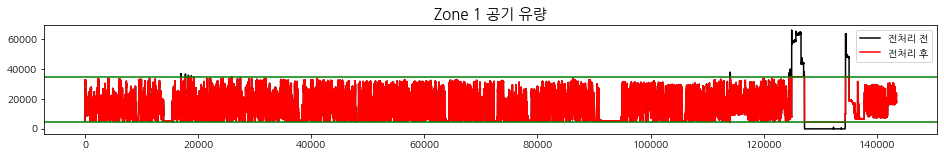

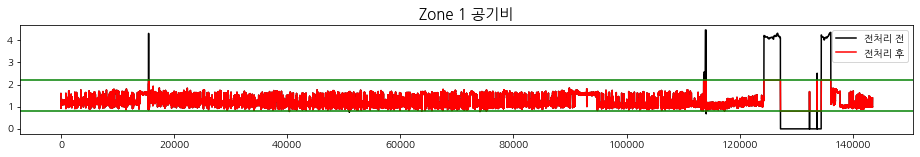

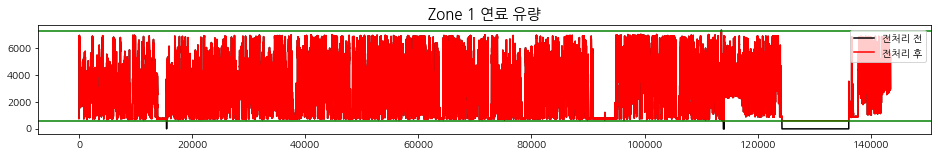

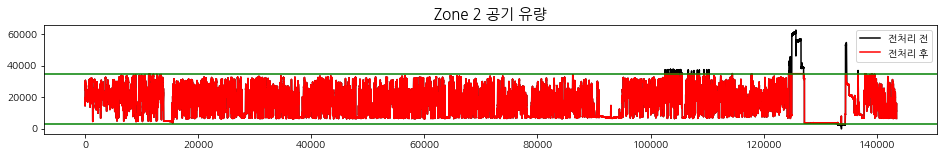

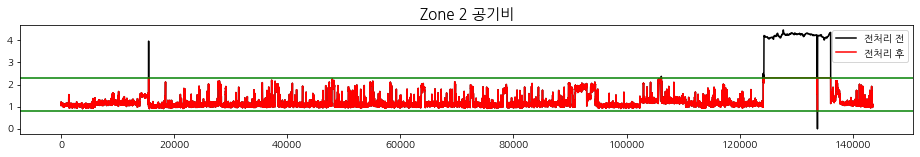

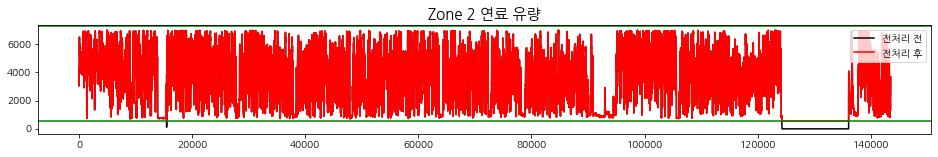

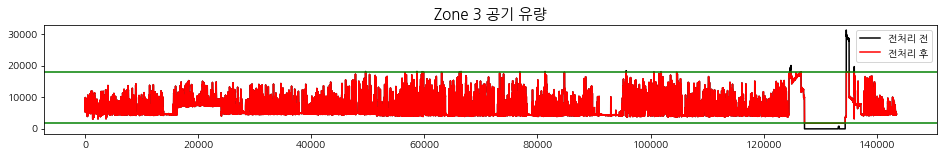

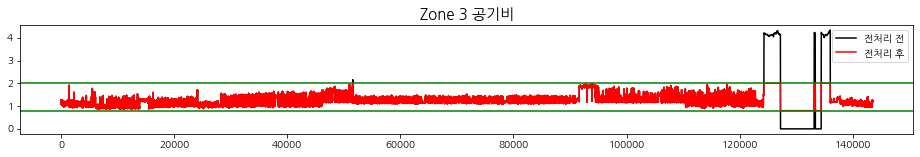

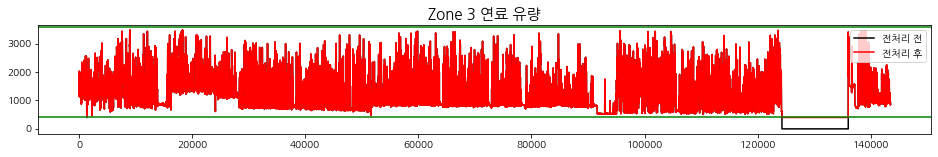

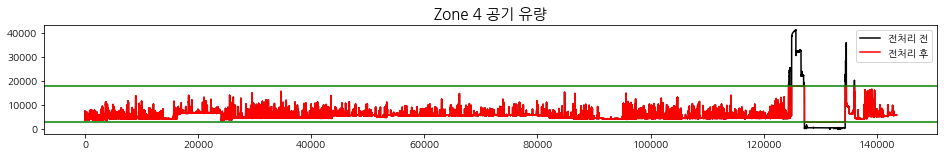

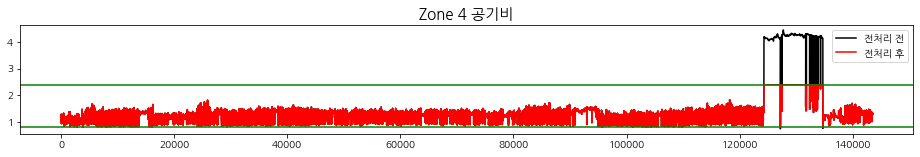

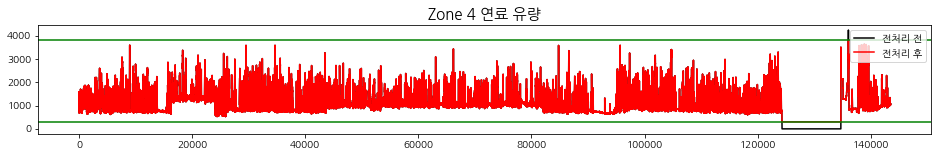

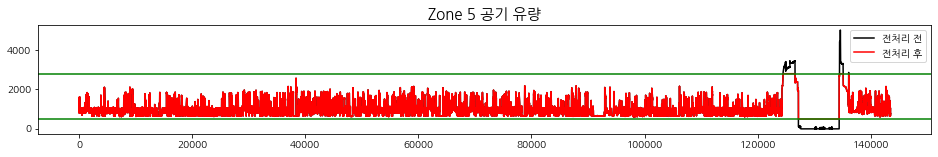

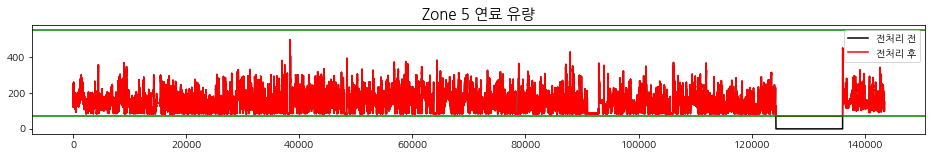

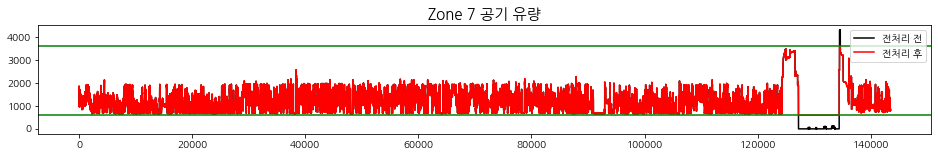

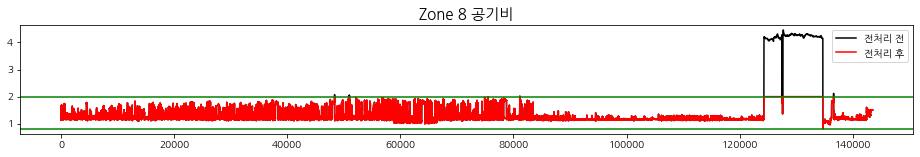

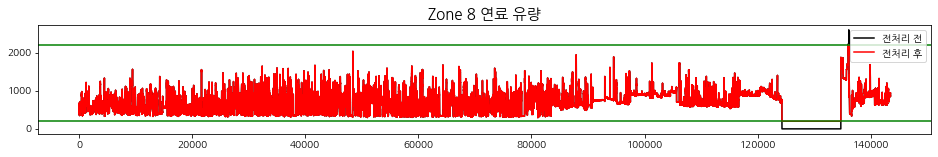

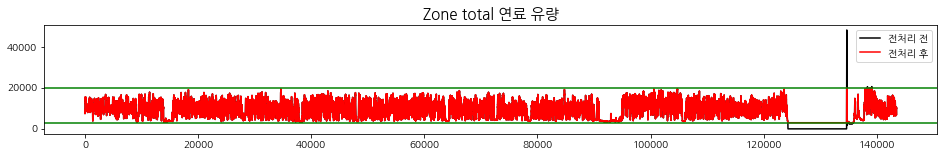

In [11]:
from utils.bandwidth_filter import *
import copy

filtered = copy.deepcopy(train_data)
for tag in list(tag_desc['Tag'].values):
    
    tag_index = list(tag_desc['Tag'].values).index(tag)
    high = tag_desc['High'][tag_index]
    low = tag_desc['Low'][tag_index]
    
    filtered.loc[train_data[tag]<=low, tag]=low
    filtered.loc[train_data[tag]>=high, tag]=high
    
    plt.figure(figsize=(16, 2))
    plt.plot(train_data[tag].values, c='k', label='전처리 전')
    plt.plot(filtered[tag].values, c='r', label='전처리 후')
    plt.axhline(y=tag_desc['High'][tag_index], c='g')
    plt.axhline(y=tag_desc['Low'][tag_index], c='g')
    plt.title(tag, fontsize=15)
    plt.legend(loc='upper right')
    plt.show();

In [12]:
# 이상 구간 제거
filtered = filtered[train_data['Zone 1 연료 유량'] != 0]

In [13]:
# X, Y 변수 설정 - 연소 최적화 개념에 따른 모니터링 변수 설정
"""
Y: O2, CO (단, 배기구 O2를 제외하고 나머지 O2를 이용하여 가열로 내부의 연소 상태를 확인하고자 함)
X: Y 변수를 제외한 모든 공정 변수 데이터
"""
all_vars = filtered.columns.to_list()

y_vars = ['예열대 상부 O2 측정값', '예열대 하부 O2 측정값', '균열대 하부 O2 측정값', '예열대 상부 CO 측정값']
except_vars = 'O2 (배기구) '

x_vars = [x for x in all_vars if (x not in y_vars) and (x not in except_vars)]
x_vars

['Damper 개도',
 'Main 공기 유량',
 'Zone 1 공기 유량',
 'Zone 1 공기비',
 'Zone 1 로온도',
 'Zone 1 연료 유량',
 'Zone 2 공기 유량',
 'Zone 2 공기비',
 'Zone 2 로온도',
 'Zone 2 연료 유량',
 'Zone 3 공기 유량',
 'Zone 3 공기비',
 'Zone 3 연료 유량',
 'Zone 4 공기 유량',
 'Zone 4 공기비',
 'Zone 4 연료 유량',
 'Zone 5 공기 유량',
 'Zone 5 로온도',
 'Zone 5 연료 유량',
 'Zone 6 공기 유량',
 'Zone 6 공기비',
 'Zone 6 로온도',
 'Zone 6 연료 유량',
 'Zone 7 공기 유량',
 'Zone 7 로온도',
 'Zone 7 연료 유량',
 'Zone 8 공기비',
 'Zone 8 로온도',
 'Zone 8 연료 유량',
 'Zone total 연료 유량',
 '노압',
 '소재 추출 온도 Pyrometer',
 '연소공기 온도',
 '열교환기 전단 배가스 온도',
 '열교환기 후단 배가스 온도',
 '장입 Door 열림 신호']

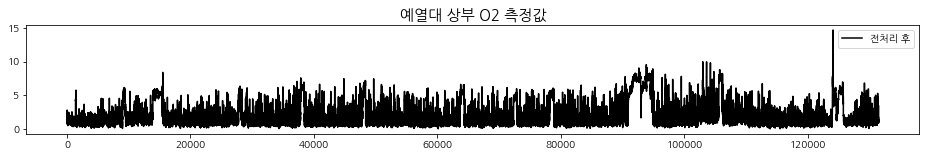

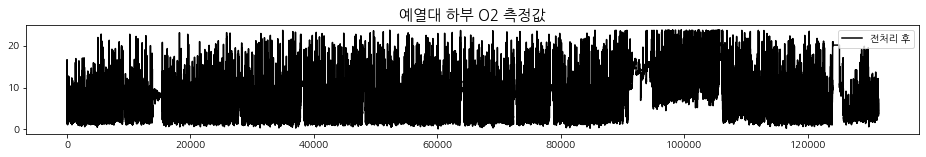

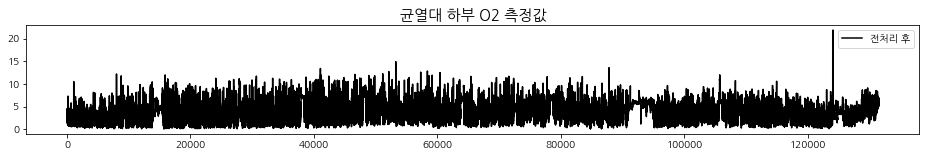

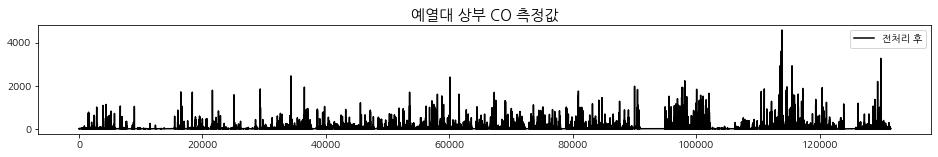

In [14]:
for y in y_vars:
    plt.figure(figsize=(16, 2))
    # plt.plot(train_data[y].values, c='k', label='전처리 전')
    plt.plot(filtered[y].values, c='k', label='전처리 후')
    plt.title(y, fontsize=15)
    plt.legend(loc='upper right')
    plt.show();

In [15]:
# 기초 통계량 확인
pd.DataFrame(filtered[y_vars].describe())

,예열대 상부 O2 측정값,예열대 하부 O2 측정값,균열대 하부 O2 측정값,예열대 상부 CO 측정값
count,131508.000000,131508.000000,131508.000000,131508.000000
mean,1.825969,5.488512,3.693387,32.775565
std,1.563347,4.451062,1.528378,107.427361
min,0.045965,0.122087,0.128131,5.787037
25%,0.961741,2.458211,2.773901,11.574074
50%,1.262373,3.569924,3.485693,12.982117
75%,1.842947,7.334743,4.344400,13.512283
max,14.693853,23.758682,21.866210,4592.124096


In [16]:
# 기초 통계량 확인
pd.DataFrame(test_data[y_vars].describe())

,예열대 상부 O2 측정값,예열대 하부 O2 측정값,균열대 하부 O2 측정값,예열대 상부 CO 측정값
count,74231.000000,74231.000000,74231.000000,74231.000000
mean,1.883687,5.684029,5.168521,64.778757
std,1.755798,3.658576,1.671576,187.651512
min,0.052147,0.362535,0.483521,8.178035
25%,0.935472,3.257553,4.174541,11.574074
50%,1.291972,4.626467,5.056189,12.920249
75%,2.064480,7.043204,5.919505,26.041668
max,16.722784,23.758682,22.320646,4561.021851


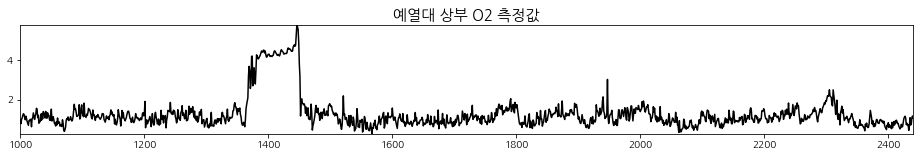

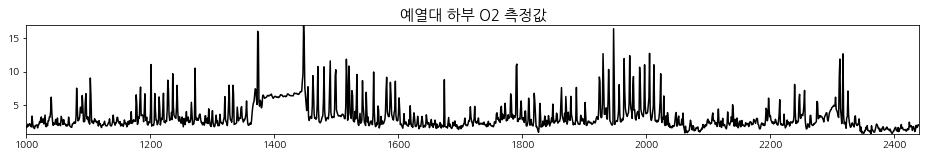

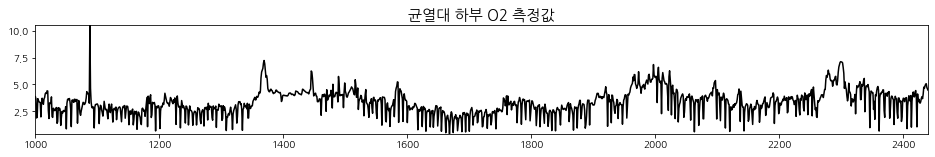

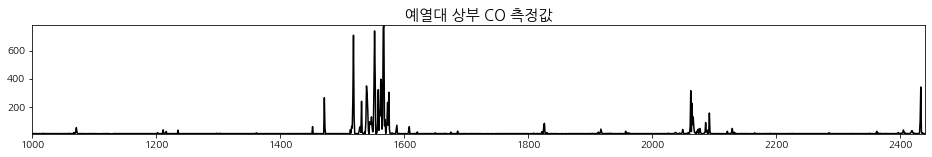

In [17]:
# 데이터 분석 - 시계열 분석
for y in y_vars:
    plt.figure(figsize=(16, 2))
    plt.plot(filtered[y].values, c='k')
    plt.title(y, fontsize=15)
    plt.xlim(1000, 2440)
    plt.ylim(filtered[y][1000:2440].min(), filtered[y][1000:2440].max())
    plt.show();

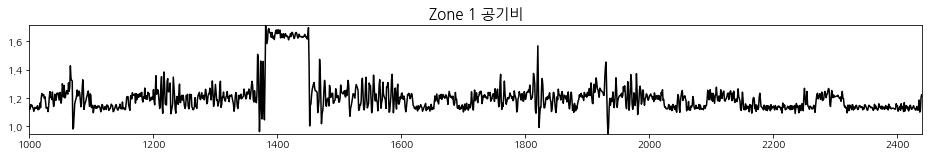

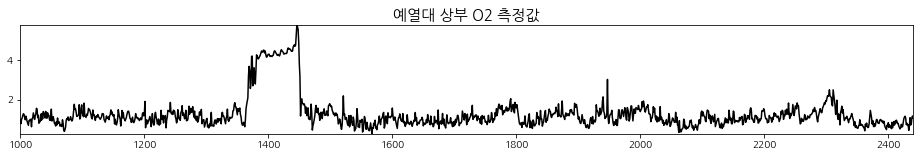

In [18]:
# 주요 변수 시계열 추이 분석
# 데이터 분석 - 시계열 분석
set_tags = ['Zone 1 공기비', '예열대 상부 O2 측정값']
for x in set_tags:
    plt.figure(figsize=(16, 2))
    plt.plot(filtered[x].values, c='k')
    plt.title(x, fontsize=15)
    plt.xlim(1000, 2440)
    plt.ylim(filtered[x][1000:2440].min(), filtered[x][1000:2440].max())
    plt.show();

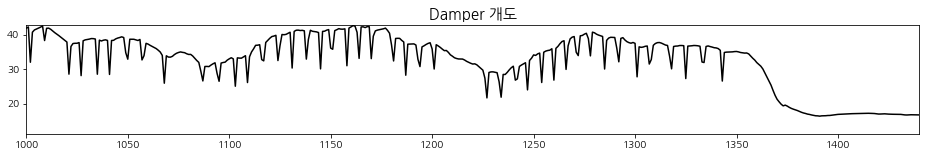

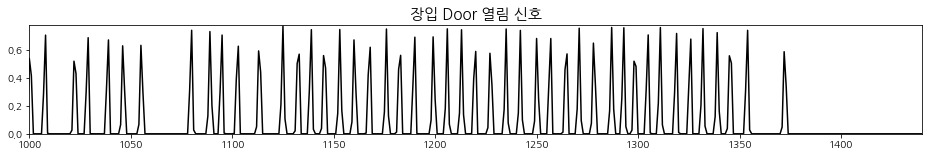

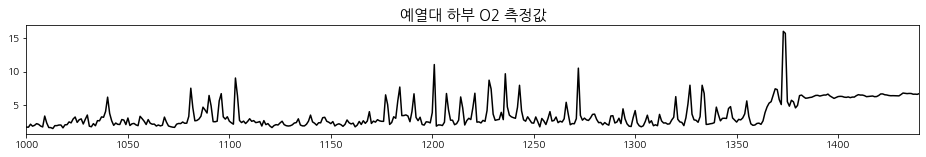

In [19]:
# 주요 변수 시계열 추이 분석
# 데이터 분석 - 시계열 분석
set_tags = ['Damper 개도', '장입 Door 열림 신호', '예열대 하부 O2 측정값']
for x in set_tags:
    plt.figure(figsize=(16, 2))
    plt.plot(filtered[x].values, c='k')
    plt.title(x, fontsize=15)
    plt.xlim(1000, 1440)
    plt.ylim(filtered[x][1000:2440].min(), filtered[x][1000:2440].max())
    plt.show();

In [20]:
# 변수 선택
# SFS 적용
from Modellings.SFS_TD import *

In [22]:
y_vars

['예열대 상부 O2 측정값', '예열대 하부 O2 측정값', '균열대 하부 O2 측정값', '예열대 상부 CO 측정값']

In [24]:
selected_columns_list = {}
importance_init_list = {}
essential_list = {"예열대 상부 O2 측정값":['Zone 1 공기비', 'Zone 2 공기비'], 
                  "예열대 하부 O2 측정값":['장입 Door 열림 신호'],
                  "균열대 하부 O2 측정값": None}
for y in y_vars:
    if y == '예열대 상부 CO 측정값':
        break
    size=int(0.8 * len(filtered))
    tmp_train, tmp_test = filtered.iloc[:size, :][::10], filtered.iloc[size:, :][::10]
    sfs_td = SFS_TD(model_type='LightGBM')
    sfs_td.run(essentials=essential_list[y],
              var_num=15,
              x_train=tmp_train[x_vars],
              x_test=tmp_test[x_vars],
              y_train=tmp_train[[y]],
              y_test=tmp_test[[y]])
    selected_columns_list[y] = sfs_td.selected_columns
    
    importance_init = sfs_td.importance0
    importance_init_list[y] = importance_init

print(selected_columns_list)

init
set_essential
selecting....
1/34 선택된 변수의 개수: 3
2/34 선택된 변수의 개수: 4
3/34 선택된 변수의 개수: 5
4/34 선택된 변수의 개수: 6
5/34 선택된 변수의 개수: 6
6/34 선택된 변수의 개수: 7
7/34 선택된 변수의 개수: 8
8/34 선택된 변수의 개수: 9
9/34 선택된 변수의 개수: 10
10/34 선택된 변수의 개수: 11
11/34 선택된 변수의 개수: 12
12/34 선택된 변수의 개수: 12
13/34 선택된 변수의 개수: 13
14/34 선택된 변수의 개수: 14
15/34 선택된 변수의 개수: 15
16/34 선택된 변수의 개수: 16
init
set_essential
selecting....
1/35 선택된 변수의 개수: 2
2/35 선택된 변수의 개수: 3
3/35 선택된 변수의 개수: 4
4/35 선택된 변수의 개수: 5
5/35 선택된 변수의 개수: 5
6/35 선택된 변수의 개수: 6
7/35 선택된 변수의 개수: 7
8/35 선택된 변수의 개수: 8
9/35 선택된 변수의 개수: 9
10/35 선택된 변수의 개수: 10
11/35 선택된 변수의 개수: 11
12/35 선택된 변수의 개수: 12
13/35 선택된 변수의 개수: 12
14/35 선택된 변수의 개수: 13
15/35 선택된 변수의 개수: 14
16/35 선택된 변수의 개수: 14
17/35 선택된 변수의 개수: 15
18/35 선택된 변수의 개수: 15
19/35 선택된 변수의 개수: 15
20/35 선택된 변수의 개수: 15
21/35 선택된 변수의 개수: 15
22/35 선택된 변수의 개수: 15
23/35 선택된 변수의 개수: 16
init
set_essential
selecting....
1/36 선택된 변수의 개수: 1
2/36 선택된 변수의 개수: 2
3/36 선택된 변수의 개수: 2
4/36 선택된 변수의 개수: 3
5/36 선택된 변수의 개수: 4
6/36 선택된 변수의 개수: 4
7/3

In [25]:
importance_init_list['예열대 상부 O2 측정값'].to_csv('./Data/Feature importance-SHAP-y1.csv', encoding='utf-8-sig')
importance_init_list['예열대 하부 O2 측정값'].to_csv('./Data/Feature importance-SHAP-y2.csv', encoding='utf-8-sig')
importance_init_list['균열대 하부 O2 측정값'].to_csv('./Data/Feature importance-SHAP-y3.csv', encoding='utf-8-sig')

In [26]:
y1_model_xvars = selected_columns_list['예열대 상부 O2 측정값']
y2_model_xvars = selected_columns_list['예열대 하부 O2 측정값']
y3_model_xvars = selected_columns_list['균열대 하부 O2 측정값']
y4_model_xvars = x_vars

In [27]:
y1_model_xvars

['Zone 1 공기비',
 'Zone 2 공기비',
 'Zone total 연료 유량',
 '열교환기 후단 배가스 온도',
 'Zone 2 연료 유량',
 'Zone 1 공기 유량',
 'Zone 4 공기비',
 '소재 추출 온도 Pyrometer',
 'Damper 개도',
 '노압',
 'Zone 1 연료 유량',
 'Zone 4 연료 유량',
 'Zone 2 로온도',
 'Zone 6 공기 유량',
 '연소공기 온도',
 'Zone 8 연료 유량']

In [28]:
y2_model_xvars

['장입 Door 열림 신호',
 '열교환기 후단 배가스 온도',
 'Zone total 연료 유량',
 'Main 공기 유량',
 'Damper 개도',
 '노압',
 '소재 추출 온도 Pyrometer',
 'Zone 3 공기비',
 '연소공기 온도',
 '열교환기 전단 배가스 온도',
 'Zone 1 공기 유량',
 'Zone 1 연료 유량',
 'Zone 8 연료 유량',
 'Zone 3 연료 유량',
 'Zone 6 연료 유량',
 'Zone 4 공기 유량']

In [29]:
y3_model_xvars

['Zone total 연료 유량',
 'Damper 개도',
 '노압',
 '소재 추출 온도 Pyrometer',
 'Zone 4 공기비',
 'Zone 3 공기비',
 'Zone 4 연료 유량',
 'Zone 3 연료 유량',
 'Zone 1 공기비',
 'Zone 2 연료 유량',
 'Zone 5 공기 유량',
 '열교환기 후단 배가스 온도',
 'Main 공기 유량',
 'Zone 5 연료 유량',
 'Zone 2 공기 유량',
 'Zone 4 공기 유량']

In [30]:
y4_model_xvars

['Damper 개도',
 'Main 공기 유량',
 'Zone 1 공기 유량',
 'Zone 1 공기비',
 'Zone 1 로온도',
 'Zone 1 연료 유량',
 'Zone 2 공기 유량',
 'Zone 2 공기비',
 'Zone 2 로온도',
 'Zone 2 연료 유량',
 'Zone 3 공기 유량',
 'Zone 3 공기비',
 'Zone 3 연료 유량',
 'Zone 4 공기 유량',
 'Zone 4 공기비',
 'Zone 4 연료 유량',
 'Zone 5 공기 유량',
 'Zone 5 로온도',
 'Zone 5 연료 유량',
 'Zone 6 공기 유량',
 'Zone 6 공기비',
 'Zone 6 로온도',
 'Zone 6 연료 유량',
 'Zone 7 공기 유량',
 'Zone 7 로온도',
 'Zone 7 연료 유량',
 'Zone 8 공기비',
 'Zone 8 로온도',
 'Zone 8 연료 유량',
 'Zone total 연료 유량',
 '노압',
 '소재 추출 온도 Pyrometer',
 '연소공기 온도',
 '열교환기 전단 배가스 온도',
 '열교환기 후단 배가스 온도',
 '장입 Door 열림 신호']

In [31]:
# 머신러닝 기법 선정
from pycaret.regression import *

In [32]:
# pycaret 셋업  # 데이터 개수가 많아 시간이 많이 걸리므로 데이터를 10분 단위로 추출함.
sup = setup(filtered[y1_model_xvars + [y_vars[0]]][::10], 
            target = y_vars[0], 
            train_size = 0.8,
            fold=4)

,Description,Value
0,session_id,3907
1,Target,예열대 상부 O2 측정값
2,Original Data,"(13151, 17)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10520, 16)"


In [33]:
top_3 = compare_models(sort='RMSE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2130,0.0905,0.3008,0.9627,0.1130,0.1727,0.7925
lightgbm,Light Gradient Boosting Machine,0.2143,0.0948,0.3069,0.9610,0.1105,0.1669,0.0775
xgboost,Extreme Gradient Boosting,0.2195,0.0951,0.3082,0.9609,0.1140,0.1695,0.7700
rf,Random Forest Regressor,0.2187,0.0958,0.3092,0.9606,0.1152,0.1755,1.9650
gbr,Gradient Boosting Regressor,0.2361,0.1050,0.3236,0.9568,0.1190,0.1851,1.1700
dt,Decision Tree Regressor,0.3165,0.2018,0.4491,0.9169,0.1677,0.2442,0.0475
lr,Linear Regression,0.3346,0.2138,0.4621,0.9121,0.1613,0.2417,1.0325
ridge,Ridge Regression,0.3349,0.2138,0.4621,0.9122,0.1616,0.2421,0.0100
br,Bayesian Ridge,0.3348,0.2138,0.4621,0.9122,0.1616,0.2419,0.0075
lar,Least Angle Regression,0.3428,0.2198,0.4684,0.9097,0.1669,0.2496,0.0075


In [34]:
# 가능성 있는 머신러닝 기법을 조합하여 새로운 모델을 개발
blended_model = blend_models(estimator_list = top_3, optimize = 'RMSE', fold=3)    # 가능성 높은 모델을 조합하기 때문에 Fold는 3회만 진행하여 시간을 절약한다.

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2030,0.0809,0.2845,0.9653,0.1061,0.1603
1,0.2095,0.0870,0.2950,0.9644,0.1085,0.1633
2,0.2097,0.0868,0.2946,0.9656,0.1120,0.1713
Mean,0.2074,0.0849,0.2914,0.9651,0.1089,0.1650
Std,0.0031,0.0028,0.0049,0.0005,0.0024,0.0046


In [35]:
# 머신러닝 모델 최종 상태 수립
blended_model = finalize_model(blended_model)

In [36]:
# 시험 데이터를 이용한 Y Data 예측
predictions = predict_model(blended_model, data=test_data[x_vars])['Label']
train_predictions = predict_model(blended_model, data=filtered[x_vars])['Label']

In [37]:
# 예측값과 시험 데이터를 비교하여 평가함.
print(calc_y_metrics(y_true=test_data[[y_vars[0]]], y_pred=predictions.values))
print(calc_y_metrics(y_true=filtered[[y_vars[0]]], y_pred=train_predictions.values))

{'R2': 0.934, 'RA': 0.801, 'MSE': 0.38109, 'Y_Avg': 1.884, 'Y_Std': 1.756, 'Error_avg': 0.37544, 'Error_std': 0.49}
{'R2': 0.972, 'RA': 0.899, 'MSE': 0.06807, 'Y_Avg': 1.826, 'Y_Std': 1.563, 'Error_avg': 0.18449, 'Error_std': 0.184}


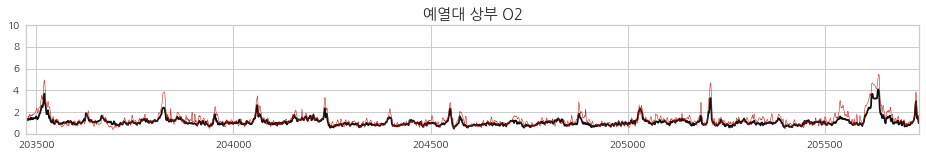

In [40]:
# 시각화
total_predict = pd.concat([train_predictions, predictions], axis=0)
total_y = pd.concat([filtered[y_vars[0]], test_data[y_vars[0]]], axis=0)

plt.figure(figsize=(16,2))
plt.plot(total_predict.values, c='k')
plt.plot(total_y.values, c='r', linewidth=0.5)
plt.xlim(int(len(total_predict)*0.989), len(total_predict))
plt.ylim(0, 10)
plt.title("예열대 상부 O2", fontsize=15)
plt.show();

<pre><strong>
연소 최적화를 위한 예측 타겟 중 첫번째 변수인, 
예열대 상부 O2는 시험 데이터 기준으로 결정계수 R2Y 93.4%의 매우 예측력이 좋은 모습을 보인다.

위 결과를 바탕으로 머신러닝 예측 모델로 O2 센서를 이중화하여 가열로 공정을 모니터링 할 수 있다고 판단한다.

위의 과정을 반복하여 총 4개의 연소 최적화를 위한 예측 타겟에 대한 예측 모델을 수립한다.
이는 아래와 같다.
</strong>
</pre>

In [41]:
# Model 및 예측 데이터 저장
joblib.dump(blended_model, './model/Y1.pkl')
predictions.to_csv('./predict_result/Y1_predict.csv', encoding='utf-8-sig')

-------------

In [42]:
# pycaret 셋업  # 데이터 개수가 많아 시간이 많이 걸리므로 데이터를 10분 단위로 추출함.
sup = setup(filtered[y2_model_xvars + [y_vars[1]]][::10], 
            target = y_vars[1],
            train_size = 0.8,
            fold=4)

,Description,Value
0,session_id,7454
1,Target,예열대 하부 O2 측정값
2,Original Data,"(13151, 17)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10520, 16)"


In [43]:
top_3 = compare_models(sort='RMSE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.1579,3.4556,1.8587,0.8248,0.2572,0.2596,0.0925
et,Extra Trees Regressor,1.1681,3.4736,1.8636,0.8240,0.2600,0.2698,0.7225
rf,Random Forest Regressor,1.1680,3.5757,1.8906,0.8188,0.2617,0.2682,2.1550
xgboost,Extreme Gradient Boosting,1.1976,3.6629,1.9136,0.8144,0.2656,0.2678,0.8225
gbr,Gradient Boosting Regressor,1.2474,3.8039,1.9502,0.8071,0.2672,0.2788,1.1400
lr,Linear Regression,1.6063,5.4680,2.3375,0.7232,0.3482,0.3780,0.0075
ridge,Ridge Regression,1.6064,5.4680,2.3375,0.7232,0.3482,0.3780,0.0075
br,Bayesian Ridge,1.6076,5.4686,2.3376,0.7232,0.3480,0.3781,0.0100
en,Elastic Net,1.6831,5.7608,2.3989,0.7085,0.3522,0.3951,0.0375
lasso,Lasso Regression,1.6876,5.7737,2.4016,0.7078,0.3515,0.3958,0.0350


In [44]:
# 가능성 있는 머신러닝 기법을 조합하여 새로운 모델을 개발
blended_model = blend_models(estimator_list = top_3, optimize = 'RMSE', fold=3)    # 가능성 높은 모델을 조합하기 때문에 Fold는 3회만 진행하여 시간을 절약한다.

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1389,3.3065,1.8184,0.8374,0.2480,0.2578
1,1.1401,3.4441,1.8558,0.8274,0.2557,0.2609
2,1.1615,3.4347,1.8533,0.8188,0.2594,0.2664
Mean,1.1468,3.3951,1.8425,0.8278,0.2544,0.2617
Std,0.0104,0.0628,0.0171,0.0076,0.0047,0.0035


In [45]:
# 머신러닝 모델 최종 상태 수립
blended_model = finalize_model(blended_model)
# 시험 데이터를 이용한 Y Data 예측
predictions = predict_model(blended_model, data=test_data[y2_model_xvars])['Label']
train_predictions = predict_model(blended_model, data=filtered[y2_model_xvars])['Label']
# 예측값과 시험 데이터를 비교하여 평가함.
print(calc_y_metrics(y_true=test_data[[y_vars[1]]], y_pred=predictions.values))
print(calc_y_metrics(y_true=filtered[[y_vars[1]]], y_pred=train_predictions.values))

{'R2': 0.734, 'RA': 0.771, 'MSE': 3.97457, 'Y_Avg': 5.684, 'Y_Std': 3.659, 'Error_avg': 1.29922, 'Error_std': 1.512}
{'R2': 0.864, 'RA': 0.82, 'MSE': 2.70171, 'Y_Avg': 5.489, 'Y_Std': 4.451, 'Error_avg': 0.98926, 'Error_std': 1.313}


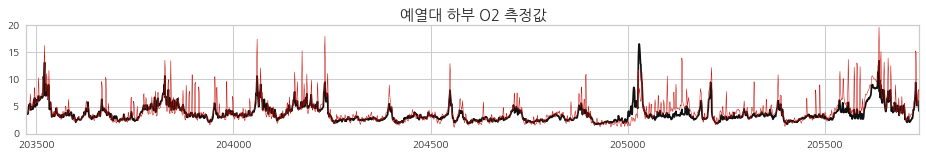

In [47]:
# 시각화
total_predict = pd.concat([train_predictions, predictions], axis=0)
total_y = pd.concat([filtered[y_vars[1]], test_data[y_vars[1]]], axis=0)
plt.figure(figsize=(16,2))
plt.plot(total_predict.values, c='k')
plt.plot(total_y.values, c='r', linewidth=0.5)
plt.xlim(int(len(total_predict)*0.989), len(total_predict))
plt.ylim(0, 20)
plt.title(y_vars[1], fontsize=15)
plt.show();

In [48]:
# Model 및 예측 데이터 저장
joblib.dump(blended_model, './model/Y2.pkl')
predictions.to_csv('./predict_result/Y2_predict.csv', encoding='utf-8-sig')

--------------------------

In [50]:
# pycaret 셋업  # 데이터 개수가 많아 시간이 많이 걸리므로 데이터를 10분 단위로 추출함.
sup = setup(filtered[y3_model_xvars + [y_vars[2]]][::10], 
            target = y_vars[2], 
            train_size = 0.8,
            fold=4)

,Description,Value
0,session_id,6189
1,Target,균열대 하부 O2 측정값
2,Original Data,"(13151, 17)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10520, 16)"


In [51]:
top_3 = compare_models(sort='RMSE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5158,0.5178,0.7194,0.7727,0.1592,0.1722,0.0675
et,Extra Trees Regressor,0.5219,0.5376,0.7331,0.7640,0.1664,0.1839,0.7425
xgboost,Extreme Gradient Boosting,0.5349,0.5616,0.7493,0.7535,0.1661,0.1777,0.7600
rf,Random Forest Regressor,0.5309,0.5674,0.7531,0.7510,0.1683,0.1849,1.9975
gbr,Gradient Boosting Regressor,0.5593,0.6043,0.7771,0.7349,0.1728,0.1917,1.1425
lr,Linear Regression,0.6755,0.8546,0.9243,0.6247,0.2014,0.2268,0.0100
ridge,Ridge Regression,0.6756,0.8546,0.9243,0.6247,0.2013,0.2268,0.0075
br,Bayesian Ridge,0.6757,0.8547,0.9244,0.6247,0.2013,0.2269,0.0100
en,Elastic Net,0.7217,0.9904,0.9951,0.5652,0.2144,0.2453,0.4900
ada,AdaBoost Regressor,0.7848,1.0093,1.0043,0.5569,0.2356,0.3064,0.2775


In [52]:
# 가능성 있는 머신러닝 기법을 조합하여 새로운 모델을 개발
blended_model = blend_models(estimator_list = top_3, optimize = 'RMSE', fold=3)    # 가능성 높은 모델을 조합하기 때문에 Fold는 3회만 진행하여 시간을 절약한다.

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5159,0.5079,0.7127,0.7842,0.1629,0.1805
1,0.5057,0.5292,0.7275,0.7713,0.1597,0.1736
2,0.5028,0.4903,0.7002,0.7741,0.1560,0.1660
Mean,0.5081,0.5091,0.7135,0.7766,0.1595,0.1733
Std,0.0056,0.0159,0.0111,0.0056,0.0028,0.0059


In [53]:
# 머신러닝 모델 최종 상태 수립
blended_model = finalize_model(blended_model)
# 시험 데이터를 이용한 Y Data 예측
predictions = predict_model(blended_model, data=test_data[y3_model_xvars])['Label']
train_predictions = predict_model(blended_model, data=filtered[y3_model_xvars])['Label']
# 예측값과 시험 데이터를 비교하여 평가함.
print(calc_y_metrics(y_true=test_data[[y_vars[2]]], y_pred=predictions.values))
print(calc_y_metrics(y_true=filtered[[y_vars[2]]], y_pred=train_predictions.values))

{'R2': 0.7, 'RA': 0.852, 'MSE': 1.04309, 'Y_Avg': 5.169, 'Y_Std': 1.672, 'Error_avg': 0.76569, 'Error_std': 0.676}
{'R2': 0.835, 'RA': 0.881, 'MSE': 0.38925, 'Y_Avg': 3.693, 'Y_Std': 1.528, 'Error_avg': 0.44072, 'Error_std': 0.442}


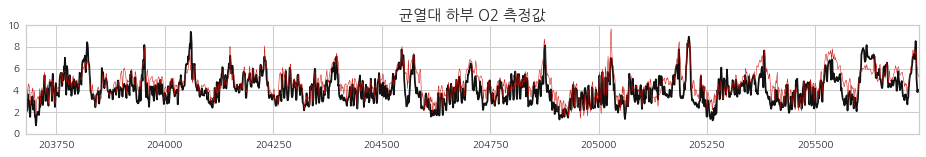

In [54]:
# 시각화
total_predict = pd.concat([train_predictions, predictions], axis=0)
total_y = pd.concat([filtered[y_vars[2]], test_data[y_vars[2]]], axis=0)

plt.figure(figsize=(16,2))
plt.plot(total_predict.values, c='k')
plt.plot(total_y.values, c='r', linewidth=0.5)
plt.xlim(int(len(total_predict)*0.99), len(total_predict))
plt.ylim(0, 10)
plt.title(y_vars[2], fontsize=15)
plt.show();

In [55]:
# Model 및 예측 데이터 저장
joblib.dump(blended_model, './model/Y3.pkl')
predictions.to_csv('./predict_result/Y3_predict.csv', encoding='utf-8-sig')

-------------

In [57]:
# 결과 분석 - 문제점 발생) CO 데이터의 경우, Peak 데이터가 많아 일반적인 관계를 찾을 수 없음.
""" --> 가열로라는 특성을 확인한다면, 연소 반응이 존재하니 분명 O2와 CO간의 관계를 가질 것으로 예상함.
    --> 따라서 CO 데이터 변수와 이름이 가장 유사한, Y1를 X변수에 넣고 모델링을 실시함.
    --> 이에 대한 정확한 관계를 얻기 위해서는 현장 도메인 지식이 반드시 필요함."""

# Y4 예측 모델 수립: CO모델은 예측력이 낮아 전체변수를 이용하였음.

# pycaret 셋업  # 데이터 개수가 많아 시간이 많이 걸리므로 데이터를 10분 단위로 추출함.
sup = setup(filtered[y4_model_xvars + [y_vars[0], y_vars[3]]][::10],
            target = y_vars[3], 
            train_size = 0.8, 
            fold=4)

,Description,Value
0,session_id,5657
1,Target,예열대 상부 CO 측정값
2,Original Data,"(13151, 38)"
3,Missing Values,False
4,Numeric Features,37
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(10520, 37)"


In [58]:
top_3 = compare_models(sort='RMSE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,16.2306,3930.4453,62.5039,0.6372,0.5174,0.4855,2.3300
lightgbm,Light Gradient Boosting Machine,15.5984,3951.1983,62.6978,0.6374,0.5125,0.4233,0.2075
rf,Random Forest Regressor,15.1284,4165.4755,64.4113,0.6159,0.4449,0.3668,7.1600
et,Extra Trees Regressor,15.3004,4220.9644,64.6767,0.6174,0.4625,0.4337,1.5600
xgboost,Extreme Gradient Boosting,15.6517,4275.2856,65.0641,0.6110,0.5104,0.4187,1.7025
dt,Decision Tree Regressor,19.6833,8181.3245,90.3075,0.2307,0.5336,0.4264,0.1700
lr,Linear Regression,39.1400,9502.5267,96.7920,0.1480,1.0617,1.9945,0.0375
ridge,Ridge Regression,39.1016,9502.4042,96.7921,0.1480,1.0607,1.9914,0.0400
en,Elastic Net,39.3637,9641.1366,97.5328,0.1345,1.0708,2.0117,0.0975
lasso,Lasso Regression,39.3758,9641.6085,97.5347,0.1344,1.0703,2.0130,0.1000


In [59]:
# 가능성 있는 머신러닝 기법을 조합하여 새로운 모델을 개발
blended_model = blend_models(estimator_list = top_3, optimize = 'RMSE', fold=3)    # 가능성 높은 모델을 조합하기 때문에 Fold는 3회만 진행하여 시간을 절약한다.

# 머신러닝 모델 최종 상태 수립
blended_model = finalize_model(blended_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14.2859,2992.7911,54.7064,0.5892,0.4469,0.3985
1,15.5842,4160.4209,64.5013,0.6742,0.4581,0.3963
2,14.3659,3888.9820,62.3617,0.7073,0.4351,0.3870
Mean,14.7453,3680.7313,60.5231,0.6569,0.4467,0.3939
Std,0.5941,498.9095,4.2048,0.0497,0.0094,0.0050


In [60]:
# 시험 데이터를 이용한 Y Data 예측
predictions = predict_model(blended_model, data=test_data[y4_model_xvars + [y_vars[0]]])['Label']
train_predictions = predict_model(blended_model, data=filtered[y4_model_xvars + [y_vars[0]]])['Label']

# 예측값과 시험 데이터를 비교하여 평가함.
print(calc_y_metrics(y_true=test_data[[y_vars[3]]], y_pred=predictions.values))
print(calc_y_metrics(y_true=filtered[[y_vars[3]]], y_pred=train_predictions.values))

{'R2': 0.764, 'RA': 0.489, 'MSE': 10651.13276, 'Y_Avg': 64.779, 'Y_Std': 187.65, 'Error_avg': 33.12368, 'Error_std': 97.744}
{'R2': 0.76, 'RA': 0.603, 'MSE': 2810.90608, 'Y_Avg': 32.776, 'Y_Std': 107.427, 'Error_avg': 13.02035, 'Error_std': 51.394}


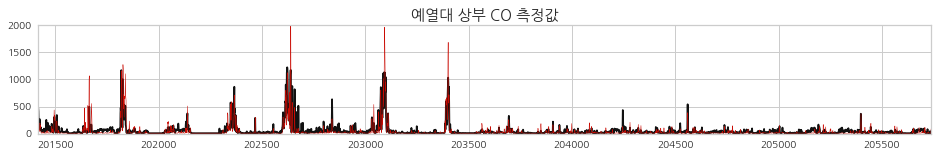

In [75]:
# 시각화
total_predict = pd.concat([train_predictions, predictions], axis=0)
total_y = pd.concat([filtered[y_vars[3]], test_data[y_vars[3]]], axis=0)

plt.figure(figsize=(16,2))
plt.plot(total_predict.values, c='k')
plt.plot(total_y.values, c='r', linewidth=0.5)
plt.xlim(int(len(total_predict)*0.979), len(total_predict))
plt.ylim(0, 2000)
plt.title(f"{y_vars[3]}", fontsize=15)
plt.show();

In [63]:
# Model 및 예측 데이터 저장
joblib.dump(blended_model, f'./model/Y4.pkl')
predictions.to_csv(f'./predict_result/Y4_predict.csv', encoding='utf-8-sig')

<pre>
위를 보면 알 수 있듯이 

예열대 상부 CO는 시험 데이터를 기준으로 결정계수 76.4%로 우수한 예측력을 보인다.
위 결과를 바탕으로 머신러닝 예측 모델로 CO 센서를 이중화하여 가열로 공정의 연소 상태, 그을음 발생 등을 모니터링 하여 나아가 폭연 등의 사고를 예방할 수 있다고 판단한다.
</pre>

### 챌린지를 통한 인사이트 도출
<pre>
조업 데이터에 머신러닝 예측 모델을 적용하여 얻을 수 있는 이점은 아래와 같다.
안정적인 설비 동작, 설계 및 사양 데이터를 충분히 아는 설비 제조사 조업방식과 최적화되고 노후화를 개선하는 경험 기반의 조업 방식에 대하여
데이터를 기반으로 한 객관적인 성능 비교 기준으로 활용될 수 있을 것이다.

더 나아가 이러한 모델을 이용하여 가열로 공정과 제조 산업 전반에서 AI를 활용한 생산 고도화와 온실가스 감축 등의 효과를 끌어낼 수 있으리라고 생각한다.
</pre>